In [46]:
import keras.backend as K

def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [47]:
#resnet18-conv_block
def conv_block(input_tensor, filters, kernel, stride = 2):
    x = Conv1D(filters, kernel_size= kernel, strides = stride, padding = 'same')(input_tensor)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters, kernel_size= kernel, strides = 1, padding = 'same')(x)
    x = BatchNormalization()(x)
    
    shortcut = Conv1D(filters, kernel_size= 1, strides = stride, padding = 'same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

In [48]:
#resnet18-Identity_block
def identity_block(input_tensor, filters, kernel):
    x = Conv1D(filters, kernel_size= kernel, strides = 1, padding = 'same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters, kernel_size= kernel, strides = 1, padding = 'same')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    
    return x

In [49]:
# using channel attention module
def attention(input_tensor):
    input_channels = int(input_tensor.shape[-1])
    x = GlobalAveragePooling1D()(input_tensor)
    x = Dense(int(input_channels/4))(x)
    x = Activation('relu')(x)
    x = Dense(input_channels)(x)
    x = Activation('sigmoid')(x)
    x = Reshape((1,  input_channels))(x)
    x = Multiply()([input_tensor, x])
    
    return x

In [50]:
def resnet_18_1D(length):
    inputs = Input((length, 1))
    x = Conv1D(64, 7, strides = 2, padding = 'same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D()(x)
    
    x = conv_block(x, 64, 3, stride = 1)
    x = identity_block(x, 64, 3)
    
    x = conv_block(x, 128, 3)
    x = identity_block(x, 128, 3)
    
    x = conv_block(x, 256, 3)
    x = identity_block(x, 256, 3)
    
    x = conv_block(x, 256, 3)
    x = identity_block(x, 256, 3)
    
    x = attention(x)
    x = GlobalAvgPool1D()(x)
    #x = Dropout(0.2)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs = inputs, outputs = x)
    
    return model

In [63]:
import tensorflow as tf
from tensorflow import keras
import tensorflow
from tensorflow import keras
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)



In [64]:
fraud.compile(optimizer = opt, loss = "binary_crossentropy", metrics=[f1])

In [ ]:
fraud.summary()

In [59]:
#save the model(every 5 epoches)
checkpoint_period = ModelCheckpoint(
                                    log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                                    monitor='val_loss', 
                                    save_weights_only=False, 
                                    save_best_only=True, 
                                    period=5
                                )

In [57]:
#reduce the lr, if the val_loss does not reduce in 3 epoches, then reduce the lr, factor is 0.5
reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss', 
                            factor=0.5, 
                            patience=3, 
                            verbose=1
                        )

In [60]:
#early stopp
early_stopping = EarlyStopping(
                            monitor='val_loss', 
                            min_delta=0, 
                            patience=10, 
                            verbose=1
                        )

In [65]:
%%time
history = fraud.fit(X_train2_, Y_train2, batch_size=64, epochs=50, validation_data=(X_test2_, Y_test2)
                   , callbacks=[checkpoint_period,early_stopping])

Epoch 1/50
1131/1131 [==============================] - 27s 24ms/step - loss: 0.1200 - f1: 0.0682 - val_loss: 0.1032 - val_f1: 0.0914
Epoch 2/50
1131/1131 [==============================] - 26s 23ms/step - loss: 0.0943 - f1: 0.1571 - val_loss: 0.1003 - val_f1: 0.1104
Epoch 3/50
1131/1131 [==============================] - 26s 23ms/step - loss: 0.0888 - f1: 0.1990 - val_loss: 0.0934 - val_f1: 0.1850
Epoch 4/50
1131/1131 [==============================] - 26s 23ms/step - loss: 0.0850 - f1: 0.2264 - val_loss: 0.0884 - val_f1: 0.2350
Epoch 5/50
1131/1131 [==============================] - 26s 23ms/step - loss: 0.0813 - f1: 0.2712 - val_loss: 0.0875 - val_f1: 0.2231
Epoch 6/50
1131/1131 [==============================] - 26s 23ms/step - loss: 0.0790 - f1: 0.2874 - val_loss: 0.0886 - val_f1: 0.2231
Epoch 7/50
1131/1131 [==============================] - 26s 23ms/step - loss: 0.0771 - f1: 0.3014 - val_loss: 0.0882 - val_f1: 0.2848
Epoch 8/50
1131/1131 [==============================] - 26s 23

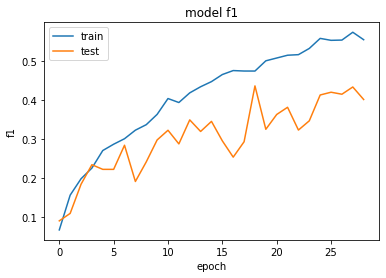

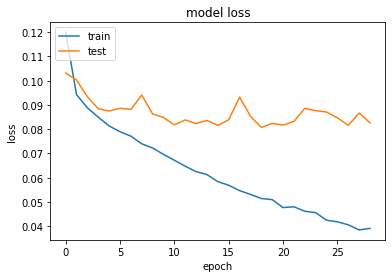

In [68]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['f1'])

plt.plot(history.history['val_f1'])

plt.title('model f1')

plt.ylabel('f1')

plt.xlabel('epoch')

plt.legend(['train','test'], loc='upper left')

plt.show()

# summarize history for loss

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train','test'], loc='upper left')
plt.show()


In [69]:
output1 = fraud.predict(X_test2_)
output0 = fraud.predict(X_train2_)

In [70]:
roc_auc_score(Y_test2, output1)

0.8850893503312365

In [ ]:
roc_auc_score(Y_train2, output0)

0.9662793836225706

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

In [ ]:
precision_recall_fscore_support(Y_test2, pred, average=None)

(array([0.98611465, 0.63684211]),
 array([0.99116517, 0.52608696]),
 array([0.98863346, 0.57619048]),
 array([7810,  230]))

<Figure size 3600x2400 with 0 Axes>

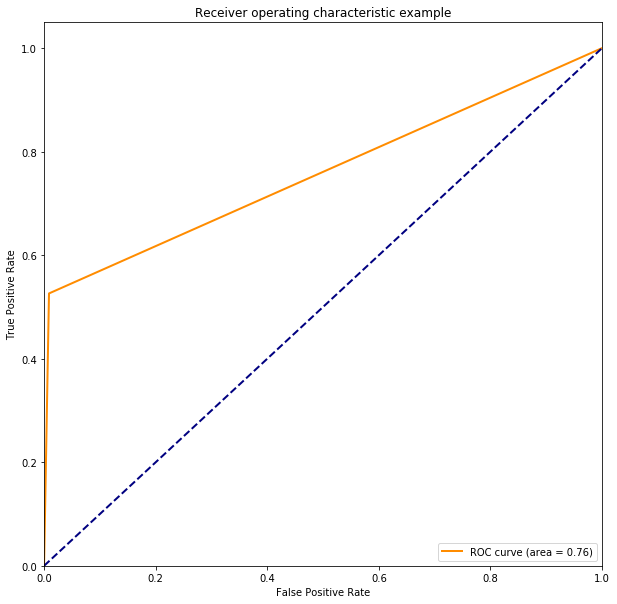

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(Y_test2, pred) # calculate false positive and true positive
roc_auc = auc(fpr,tpr) # auc


plt.figure(dpi=600)
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.savefig('resnet_600.png', dpi=600)
plt.savefig('resnet_150.png', dpi=150)